In [1]:
import numpy as np
from sanchez_ansatz import SanchezAnsatz
from qiskit_aer import Aer
from experiments import get_state
from experiments.densities import get_probability_freqs
from experiments import ExperimentModule
from qiskit import transpile
from qiskit_algorithms.optimizers import SPSA
from scipy.stats import norm
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
num_qubits = 3
state_type = "normal"
state_params = { "loc": 0.5 , "scale":  0.3, "x_points": np.array([0., 1.])}

x_points = np.linspace(state_params["x_points"][0], state_params["x_points"][1], 2**num_qubits)

freqs = get_probability_freqs(x_points, num_qubits=num_qubits, density=state_type, density_params={ "loc": state_params["loc"], "scale": state_params["loc"]})
#state  = get_state(num_qubits=num_qubits, state_type=state_type, state_params=state_params)
probs = norm.pdf(x_points, loc=state_params["loc"], scale=state_params["scale"])
target_state = probs/np.linalg.norm(probs)

computed_eta = 2/state_params["scale"]**2

sanchez_ansatz = SanchezAnsatz(target_state, eps=0.05, eta=computed_eta)
init_params = sanchez_ansatz.init_params

t_sa = transpile(sanchez_ansatz, basis_gates=["cx", "u"])

#em = ExperimentModule(
#    t_sa,
#    SPSA(maxiter=2000),
#    target_state=target_state,
#    init_params=init_params,
#)
#result = em.minimize()

In [3]:
pt_sa = t_sa.assign_parameters(init_params)
sv_sim = Aer.get_backend("statevector_simulator")
job = sv_sim.run(pt_sa)
job_result = job.result()
res_statevector = job_result.get_statevector().data

fid = np.abs(res_statevector.conj() @ target_state)**2

print("Fidelity: ", fid)
print("SanchezAnsatz k0: ", sanchez_ansatz.k0)
print("Computed eta: ", computed_eta)


Fidelity:  0.9999999999999998
SanchezAnsatz k0:  3
Computed eta:  22.22222222222222


In [4]:
print(res_statevector[:5])
print(target_state[:5])

[0.12963832+0.j 0.25595983+0.j 0.40283831+0.j 0.50537091+0.j
 0.50537091+0.j]
[0.12963832 0.25595983 0.40283831 0.50537091 0.50537091]


/home/ismael/anaconda3/envs/sanches-modified/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ismael/anaconda3/envs/sanches-modified/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


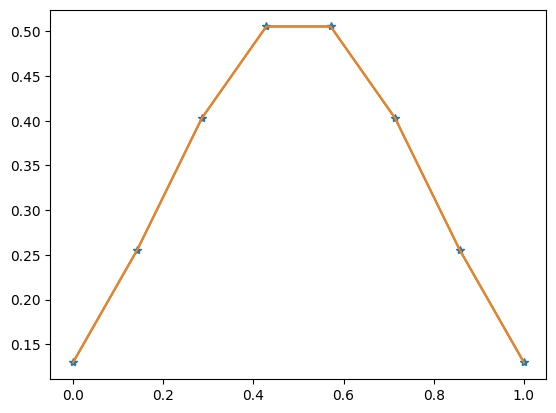

In [8]:
plt.plot(x_points, target_state, marker="*")
plt.plot(x_points, res_statevector)
plt.show()

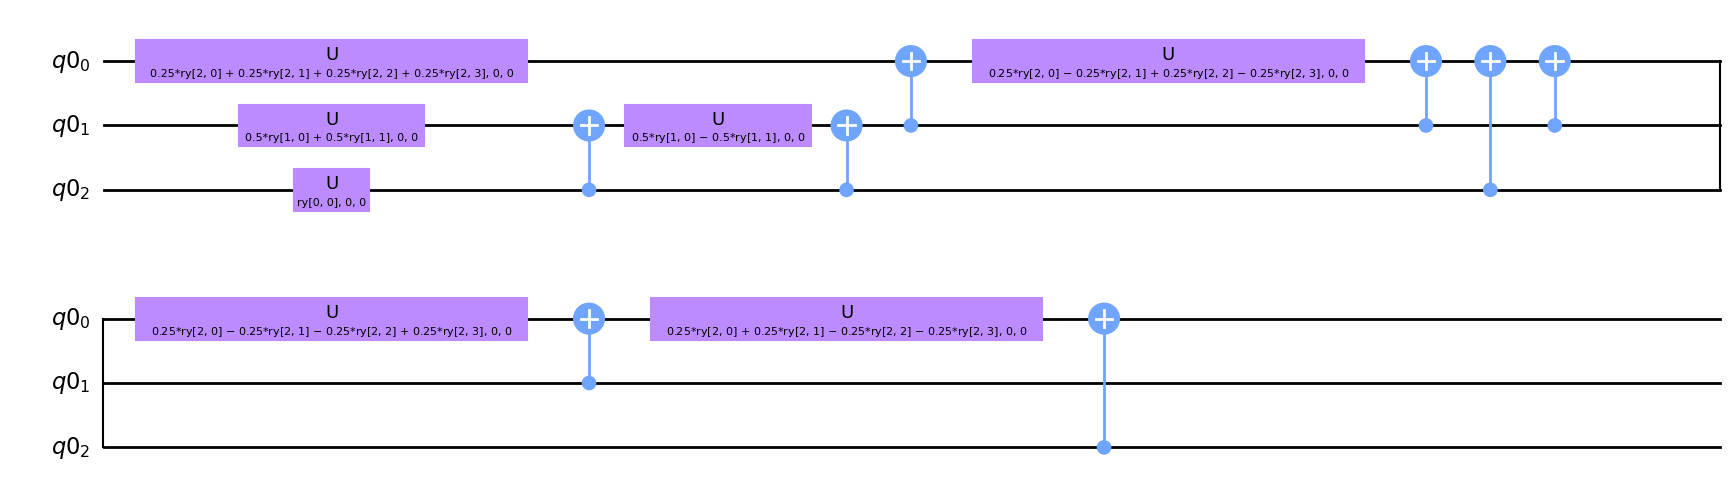

In [6]:
t_sa.draw("mpl")

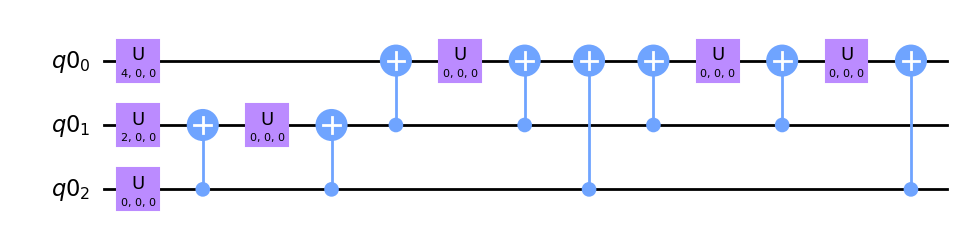

In [7]:
temp_circ = t_sa.assign_parameters([0, 2, 2, 4, 4, 4, 4])
temp_circ.draw("mpl")